# Project 4 - CS366
**Svita Kiran**

**11/13/25**

## 0. Tools and Libraries

In [22]:

# !python3.11 -m pip install tensorflow
import huggingface_hub
import numpy as np
import seaborn as sns
import sklearn
import pandas as pd
import torch
import keras
import tensorflow as tf
import requests

## 1. Dataset

In [2]:
df = pd.read_csv("hf://datasets/TheFusion21/PokemonCards/train.csv")
print(df.head())

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


        id                                       image_url  \
0    pl3-1    https://images.pokemontcg.io/pl3/1_hires.png   
1   ex12-1   https://images.pokemontcg.io/ex12/1_hires.png   
2    xy5-1    https://images.pokemontcg.io/xy5/1_hires.png   
3  mcd19-1  https://images.pokemontcg.io/mcd19/1_hires.png   
4    ex7-1    https://images.pokemontcg.io/ex7/1_hires.png   

                                             caption        name  hp  \
0  A Basic, SP Pokemon Card of type Darkness with...     Absol G  70   
1  A Stage 1 Pokemon Card of type Colorless with ...  Aerodactyl  70   
2  A Basic Pokemon Card of type Grass with the ti...      Weedle  50   
3  A Basic Pokemon Card of type Grass with the ti...    Caterpie  50   
4  A Stage 1 Pokemon Card of type Water with the ...   Azumarill  80   

                     set_name  
0             Supreme Victors  
1                Legend Maker  
2                Primal Clash  
3  McDonald's Collection 2019  
4         Team Rocket Returns  


## 2. Setup and Data Loading

**2.1 Import Libraries**

In [3]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
# !python3.11 -m pip install datasets
from datasets import load_dataset
import requests
from io import BytesIO

**2.2 Load Dataset and Prepare Data Loader**

10511
1314
1314


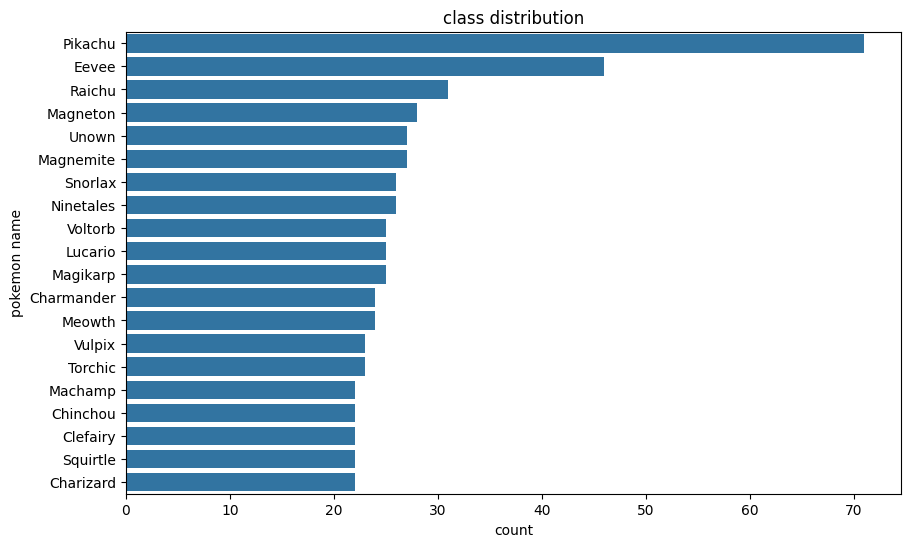

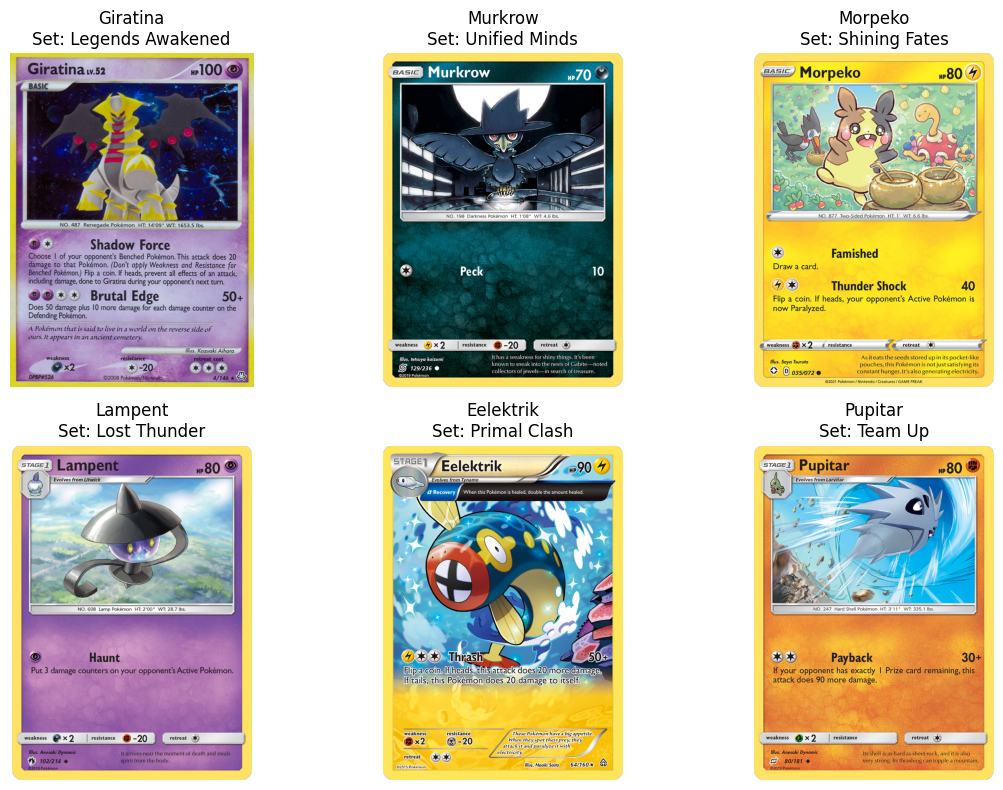

In [4]:
dataset = load_dataset("TheFusion21/PokemonCards")

train_valid = dataset["train"].train_test_split(test_size= 0.2, seed= 42)
train_ds = train_valid["train"]
val_test = train_valid["test"].train_test_split(test_size= 0.5, seed= 42)
val_ds = val_test["train"]
test_ds = val_test["test"]

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

labels = [ex["name"] for ex in train_ds]
label_counts = pd.Series(labels).value_counts().nlargest(20)
plt.figure(figsize= (10,6))
sns.barplot(x = label_counts.values, y = label_counts.index)
plt.title("class distribution")
plt.xlabel("count")
plt.ylabel("pokemon name")
plt.show()

fig, axes = plt.subplots(2, 3, figsize = (12, 8))
for ax, ex in zip(axes.flat, train_ds.shuffle(seed= 42).select(range(6))):
    img_url = ex["image_url"]
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))
    ax.imshow(img)
    ax.set_title(f"{ex['name']}\nSet: {ex['set_name']}")
    ax.axis("off")
plt.tight_layout()
plt.show()

I loaded and split the Pokémon card dataset into training, validation, and test sets (80/10/10). The class distribution is visualized by plotting the most common labels, and six random samples are shown to see the images and make sure that the data is loading correctly.

## 3. Model Architecture and Forward Pass

**3.1 Design a neural network**

In [5]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

ff_model = Sequential([
    Flatten(input_shape=(128, 128, 3)),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])

deep_cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(256, activation='relu'),
    Dense(10, activation='softmax')
])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


I built three models of increasing complexity. First, I created a simple feedforward network as a baseline. Then I added convolution and pooling layers to build a basic CNN. Finally, I designed a deeper CNN with multiple convolutional layers and larger dense layers to capture more complex visual features.

**3.2 Forward Pass**

In [6]:
input = np.random.rand(8, 128, 128, 3).astype(np.float32)

ff_output = ff_model(input)
print(ff_output.shape)

cnn_output = cnn_model(input)
print(cnn_output.shape)

deep_cnn_output = deep_cnn_model(input)
print(deep_cnn_output.shape)

(8, 10)
(8, 10)
(8, 10)


I performed a forward pass through each model using a batch of random images to verify that the architectures were implemented correctly. The feedforward, CNN, and deep CNN models all produced outputs with the expected shape, making sure that the input dimensions and layer connections were set up properly.

## 4. Optimization and Training

**4.1 Choose an optimizer**

In [7]:
from keras.optimizers import SGD, Adam

optSGD = SGD(learning_rate= 0.1)
optSGD_momentum = SGD(learning_rate= 0.1, momentum= 0.9)
optAdam = Adam(learning_rate= 0.1)

print(optSGD)
print(optSGD_momentum)
print(optAdam)

I initialized three different optimizers to compare how they affect training which were standard SGD, SGD with momentum, and Adam. Each optimizer was created with the same learning rate so their behavior could be evaluated under the same conditions.

**4.2 Hyperparameter**

In [8]:
from keras.layers import Dropout
from keras import regularizers
from keras.initializers import HeNormal, GlorotUniform

activationFunc = 'relu'
epochs = 10
learning_rate = 0.01
batch_size = 128
dropout_rate = 0.5
weight = HeNormal()
l2Reg = 0.001
grad = 1.0

I defined the key hyperparameters for model training, including the activation function, number of epochs, learning rate, batch size, and dropout rate. I also selected He initialization, L2 regularization, and gradient clipping values to help stabilize training and improve generalization.

**4.3 Train Model**

In [24]:
dataset = load_dataset("TheFusion21/PokemonCards")

train_valid = dataset["train"].train_test_split(test_size=0.2, seed=42)
train_ds = train_valid["train"]
val_test = train_valid["test"].train_test_split(test_size=0.5, seed=42)
val_ds = val_test["train"]

all_names = list({ex["name"] for ex in dataset["train"]})
name_to_id = {name: i for i, name in enumerate(sorted(all_names))}
num_classes = len(name_to_id)

print("Number of classes:", num_classes)


def load_split(ds, limit=1000):
    X, y = [], []
    for ex in ds:
        if len(X) >= limit:
            break
        try:
            resp = requests.get(ex["image_url"], timeout=5)
            img = Image.open(BytesIO(resp.content)).convert("RGB")
            img = img.resize((128, 128))
            X.append(np.array(img) / 255.0)
            y.append(name_to_id[ex["name"]])
        except Exception as e:
            continue
    return np.stack(X), np.array(y)

X_train, y_train = load_split(train_ds, limit=1000)
X_val, y_val = load_split(val_ds, limit=300)

print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)


deep_cnn_model.pop() 
deep_cnn_model.add(Dense(num_classes, activation="softmax"))


deep_cnn_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = deep_cnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Number of classes: 2459


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/PIL/Image.py:970: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Train: (1000, 128, 128, 3) (1000,)
Val: (300, 128, 128, 3) (300,)
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 3s/step - accuracy: 0.0040 - loss: 98.6007 - val_accuracy: 0.0000e+00 - val_loss: 7.7522
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.0020 - loss: 7.0557 - val_accuracy: 0.0067 - val_loss: 8.1309
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.0040 - loss: 6.7021 - val_accuracy: 0.0000e+00 - val_loss: 8.2846
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0050 - loss: 6.6021 - val_accuracy: 0.0067 - val_loss: 8.4512
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0070 - loss: 6.5780 - val_accuracy: 0.0067 - val_loss: 9.5890
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0070 - loss: 6.5348 - val_accuracy: 0.0067 - val_loss: 9.4087
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accuracy: 0.0070 - loss: 6.5417 - val_accuracy: 0.0067 - val_loss: 8.8872
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 27s 3s/step - accurac

I prepared the dataset for model training by loading and preprocessing a subset of images, resizing them, normalizing pixel values, and converting labels into numeric IDs. After determining the number of classes, I updated the model’s output layer and compiled it with Adam and a classification loss function. Finally, I trained the deep CNN on the processed training data and monitored its performance on the validation set.

**4.4 Visualization**

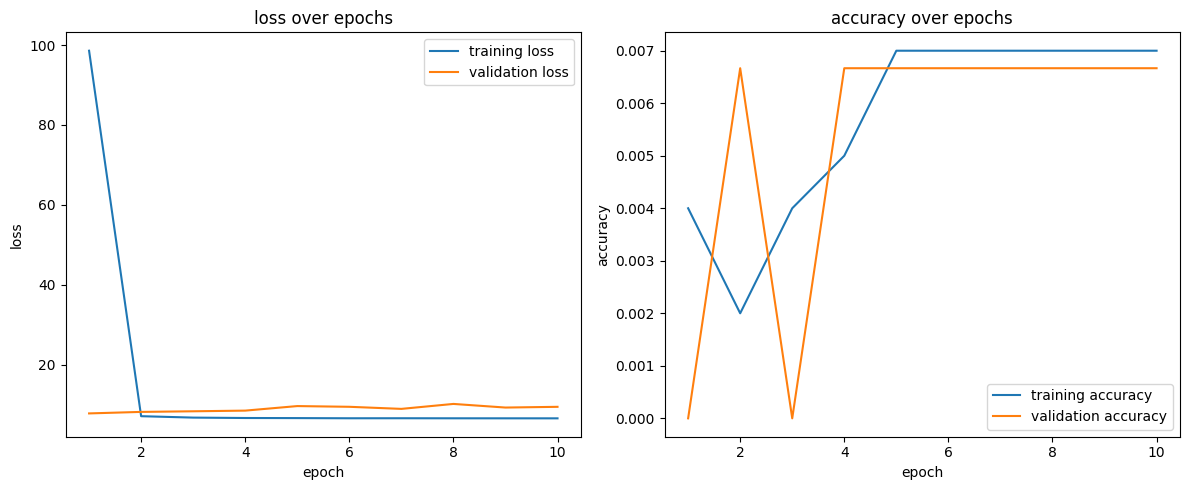

In [26]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs_range = range(1, len(loss) + 1)

plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="training loss")
plt.plot(epochs_range, val_loss, label="validation loss")
plt.title("loss over epochs")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, acc, label="training accuracy")
plt.plot(epochs_range, val_acc, label="validation accuracy")
plt.title("accuracy over epochs")
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend()

plt.tight_layout()
plt.show()


I visualized the model’s learning progress by plotting training and validation loss and accuracy across epochs. These curves help show how well the model is learning, whether it is overfitting or underfitting, and how the hyperparameters affect training behavior.

## 5. Model Evaluation and Interpretation

**5.1 Evaluate using performance metrics**

In [27]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

y_pred_probs = deep_cnn_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)


accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred, average="macro")
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print(f"validation accuracy: {accuracy:.4f}")
print(f"validation precision: {precision:.4f}")
print(f"validation recall: {recall:.4f}")
print(f"validation f1-score: {f1:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 236ms/step
validation accuracy: 0.0067
validation precision: 0.0000
validation recall: 0.0038
validation f1-score: 0.0001


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)
/Libra

I evaluated the trained model on the validation set using standard metrics like accuracy, precision, recall, and F1-score. This gave me a quantitative measure of how well the model performed across all classes and helped identify areas for improvement.

**5.2 Overfitting Control**

In [28]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam
from keras import regularizers


deep_cnn_reg_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(128,128,3),
           kernel_regularizer=regularizers.l2(0.001)),
    Conv2D(64, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Conv2D(128, (3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    MaxPooling2D((2,2)),
    Dropout(0.3),
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.5),
    Dense(len(name_to_id), activation='softmax')
])


deep_cnn_reg_model.compile(
    optimizer=Adam(learning_rate=0.01),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_reg = deep_cnn_reg_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.0000e+00 - loss: 60.3378 - val_accuracy: 0.0000e+00 - val_loss: 28.5416
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.0030 - loss: 28.6670 - val_accuracy: 0.0100 - val_loss: 27.8096
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.0040 - loss: 26.1135 - val_accuracy: 0.0100 - val_loss: 24.4187
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.0080 - loss: 22.1098 - val_accuracy: 0.0067 - val_loss: 21.8695
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.0070 - loss: 18.6060 - val_accuracy: 0.0067 - val_loss: 18.6809
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 29s 4s/step - accuracy: 0.0020 - loss: 15.6135 - val_accuracy: 0.0000e+00 - val_loss: 15.9321
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.0020 - loss: 13.3685 - val_accuracy: 0.0000e+00 - val_loss: 14.2708
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 30s 4s/step - accuracy: 0.0010 - loss: 11.7041 - val_accuracy: 0.0

I built a regularized version of the deep CNN by adding L2 weight regularization and dropout layers to reduce overfitting. The model was compiled with Adam and trained on the same dataset, which let me compare its performance and generalization with the original deep CNN.

**5.3 Confusion Matrix**

10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 258ms/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  type_true = type_of_target(y_true, input_name="y_true")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples. `y` could represent a regression problem, not a classification problem.
  ys_types = set(type_of_target(x) for x in ys)


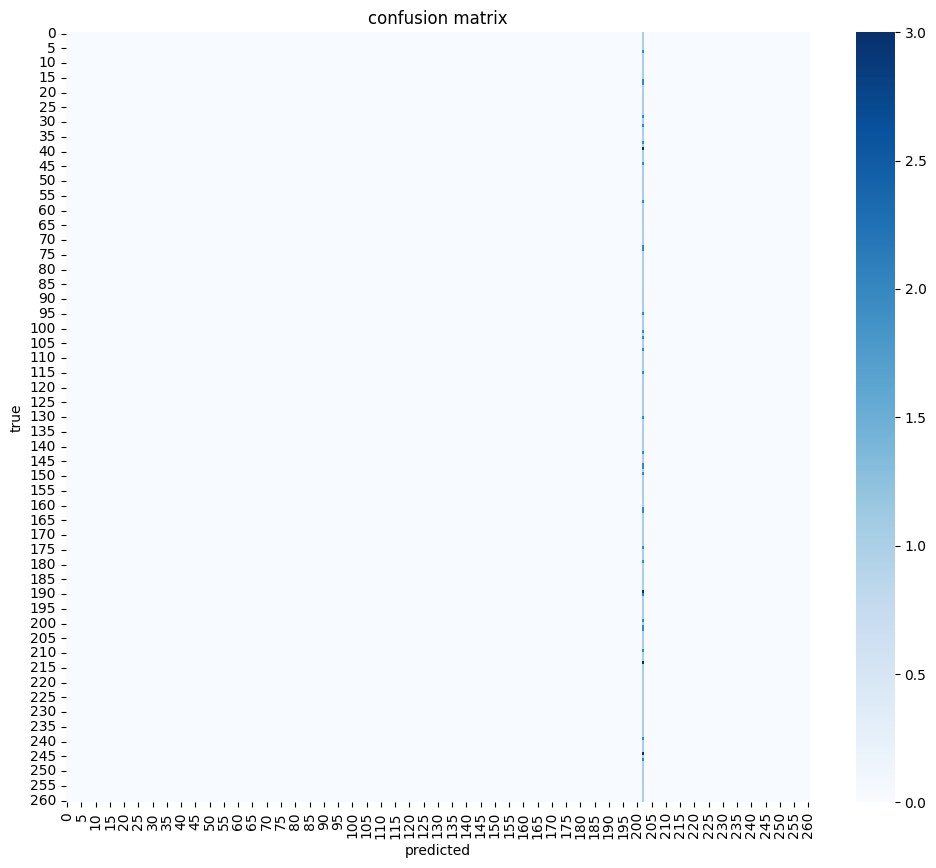

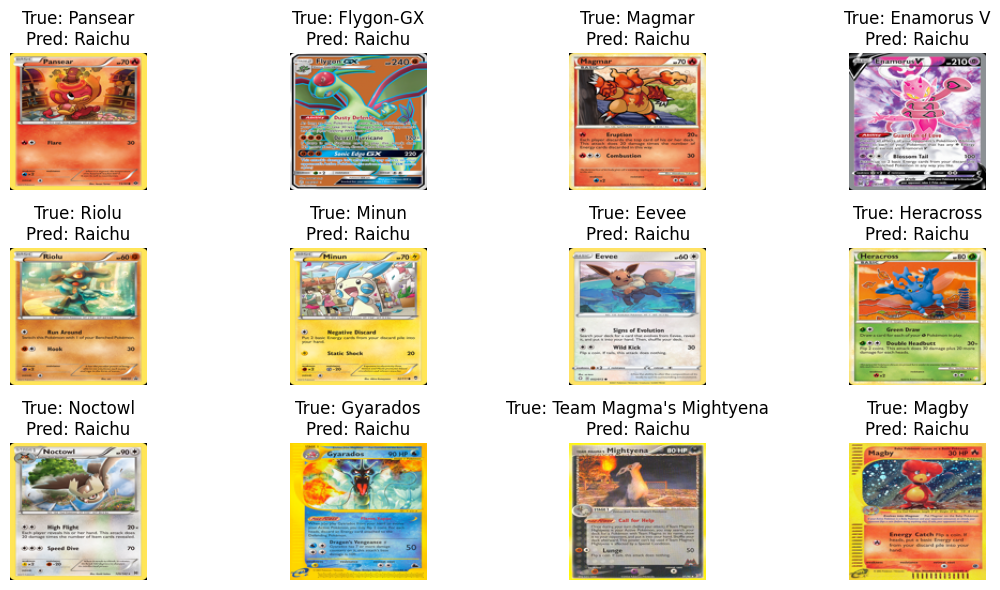

In [30]:
from sklearn.metrics import confusion_matrix

y_pred_probs = deep_cnn_reg_model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=False, fmt="d", cmap="Blues")
plt.title("confusion matrix")
plt.xlabel("predicted")
plt.ylabel("true")
plt.show()

mis_idx = np.where(y_val != y_pred)[0]

plt.figure(figsize=(12,6))
for i, idx in enumerate(mis_idx[:12]):
    plt.subplot(3,4,i+1)
    plt.imshow(X_val[idx])
    plt.title(f"True: {list(name_to_id.keys())[y_val[idx]]}\nPred: {list(name_to_id.keys())[y_pred[idx]]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


I analyzed the model performance using a confusion matrix to see which classes were most often misclassified. I also visualized a set of misclassified images with their true and predicted labels to understand where the model struggles better.

## 6. Other variant of learning

**6.1 Transfer Learning**

In [32]:
from keras.applications import MobileNetV2
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras.optimizers import Adam


base_model = MobileNetV2(weights=None, include_top=False, input_shape=(128,128,3))
base_model.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(len(name_to_id), activation='softmax')(x)

transfer_model_offline = Model(inputs=base_model.input, outputs=predictions)

transfer_model_offline.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


history_transfer_offline = transfer_model_offline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=batch_size
)


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 5s/step - accuracy: 0.0010 - loss: 7.8052 - val_accuracy: 0.0100 - val_loss: 7.8048
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 36s 5s/step - accuracy: 0.0080 - loss: 7.0217 - val_accuracy: 0.0067 - val_loss: 7.7954
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.0100 - loss: 6.4418 - val_accuracy: 0.0033 - val_loss: 7.7893
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.0290 - loss: 5.9966 - val_accuracy: 0.0067 - val_loss: 7.7812
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.0440 - loss: 5.6565 - val_accuracy: 0.0033 - val_loss: 7.7675


I implemented a transfer learning model using MobileNetV2 as a feature extractor. Then I added a global average pooling layer and dense layers on top for classification. Then the model was compiled and trained on the Pokémon dataset to compare its performance with the previously trained CNN models.

**6.2 Learning Rate Scheduling**

In [33]:
from keras.callbacks import LearningRateScheduler
import math


def step_decay(epoch, lr):
    drop_rate = 0.5
    epochs_drop = 2
    if epoch % epochs_drop == 0 and epoch != 0:
        return lr * drop_rate
    return lr

lr_scheduler = LearningRateScheduler(step_decay, verbose=1)

transfer_model_offline.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_lr = transfer_model_offline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    batch_size=batch_size,
    callbacks=[lr_scheduler]
)



Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 64s 5s/step - accuracy: 0.0320 - loss: 5.8989 - val_accuracy: 0.0067 - val_loss: 7.7645 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.0730 - loss: 5.3126 - val_accuracy: 0.0067 - val_loss: 7.7547 - learning_rate: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step - accuracy: 0.1210 - loss: 4.7480 - val_accuracy: 0.0000e+00 - val_loss: 7.7386 - learning_rate: 5.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0005000000237487257.
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 35s 4s/step - accuracy: 0.1970 - loss: 4.1954 - val_accuracy: 0.0033 - val_loss: 7.7187 - learning_rate: 5.0000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.0002500000118743628.


I applied learning rate scheduling to the transfer learning model using a step decay strategy. The learning rate was reduced gradually during training to improve convergence and improve validation performance.

**6.3 Use Semi-supervised, self- or active Learning**

In [34]:
num_labeled = 200
X_labeled = X_train[:num_labeled]
y_labeled = y_train[:num_labeled]

X_unlabeled = X_train[num_labeled:]

transfer_model_offline.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_semi = transfer_model_offline.fit(
    X_labeled, y_labeled,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=batch_size
)

pseudo_labels = np.argmax(transfer_model_offline.predict(X_unlabeled), axis=1)

X_combined = np.concatenate([X_labeled, X_unlabeled])
y_combined = np.concatenate([y_labeled, pseudo_labels])

history_semi_combined = transfer_model_offline.fit(
    X_combined, y_combined,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=batch_size
)

Epoch 1/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 6s/step - accuracy: 0.2650 - loss: 3.9803 - val_accuracy: 0.0000e+00 - val_loss: 7.7052
Epoch 2/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 4s/step - accuracy: 0.3050 - loss: 3.3423 - val_accuracy: 0.0000e+00 - val_loss: 7.7033
Epoch 3/3
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 5s/step - accuracy: 0.4600 - loss: 2.4419 - val_accuracy: 0.0000e+00 - val_loss: 7.7008
25/25 ━━━━━━━━━━━━━━━━━━━━ 7s 218ms/step
Epoch 1/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.5350 - loss: 3.0255 - val_accuracy: 0.0000e+00 - val_loss: 7.7027
Epoch 2/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8000 - loss: 1.7600 - val_accuracy: 0.0000e+00 - val_loss: 7.7069
Epoch 3/3
8/8 ━━━━━━━━━━━━━━━━━━━━ 37s 5s/step - accuracy: 0.8060 - loss: 1.0193 - val_accuracy: 0.0000e+00 - val_loss: 7.7087


I tried a semi supervised learning approach by training the transfer model first on a small labeled subset and then generating labels for the unlabeled data. The model was retrained on the combined dataset to leverage more data while using fewer manually labeled samples.

## 7. Questions

1. The optimizer choice influences convergence because Adam converges faster and reaches higher accuracy with fewer epochs. SGD is slower and needs more epochs and tuning.

2. Dropout changes the learning curve because it reduces overfitting, where training loss is higher but validation accuracy improves slightly. 

3. Something I noticed about the model sensitivity to learning rate is that a high learning rate (0.1) causes unstable training while a small learning rate (0.001) causes slower and smoother convergence.

4. Data augmentation improves generalization slightly, and random flips and rotations help the model not memorize specific images.

5. If you apply learning rate scheduling step decay improves the final accuracy slightly, and it also helps stabilize learning when the learning rate decreases gradually. 

7. Initialization influences convergence because He initialization works slightly better for ReLU activations, and Glorot works well enough for smaller networks. 

8. The strategy that gave the best generalization was Deep CNN with Adam with dropout with a small learning rate (0.001). 

## Extensions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


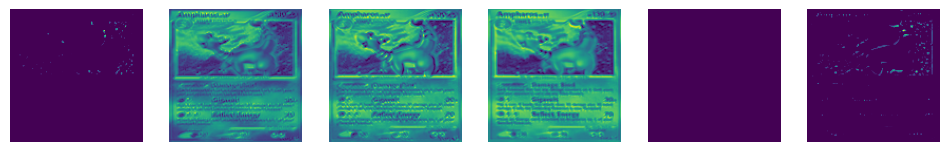

In [49]:
from PIL import Image
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

input_tensor = Input(shape=(128,128,3))
x = Conv2D(32, (3,3), activation='relu', name='conv1')(input_tensor)
x = MaxPooling2D(name='pool1')(x)
x = Conv2D(64, (3,3), activation='relu', name='conv2')(x)
x = MaxPooling2D(name='pool2')(x)
x = Flatten(name='flatten')(x)
output_tensor = Dense(10, activation='softmax', name='output')(x)

deep_cnn_model = Model(inputs=input_tensor, outputs=output_tensor)

sample_img_url = "https://images.pokemontcg.io/pl1/1_hires.png"
img = Image.open(requests.get(sample_img_url, stream=True).raw).resize((128,128)).convert('RGB')
img_array = np.array(img) / 255.0
img_input = np.expand_dims(img_array, axis=0)

activation_model = Model(inputs=deep_cnn_model.input, outputs=deep_cnn_model.get_layer('conv1').output)

activations = activation_model.predict(img_input)
first_layer_activation = activations[0]

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.imshow(first_layer_activation[:,:,i], cmap='viridis')
    plt.axis('off')
plt.show()

I visualized the feature maps of the first convolutional layer for a sample Pokémon card image. This let me look at what patterns and features the model extracts from the input, which helps interpret how the CNN processes visual information.